In [9]:
# @title Step 2: Load Data (Example: CSV with 'title', 'description')
import pandas as pd
import torch
torch.cuda.is_available()

True

In [10]:
df = pd.read_csv('filtered_dataset.csv')
df.head()

,title,authors,year,description,url,citations,cluster,type,clean_title,word_count,char_count,category,domain,publisher,path,query_params,doi,extension
0,bookb health measurement scales practical guid...,"DL Streiner, GR Norman, J Cairney",2024.0,… The intent of this book is to introduce rese...,https://books.google.com/books?hl=en&lr=&id=pb...,21116,1,BOOK,Health measurement scales: a practical guide t...,11,63,health,books.google.com,Google Books,/books,"{'hl': ['en'], 'id': ['pb30EAAAQBAJ'], 'oi': [...",NaN,NaN
1,bookb occupational perspective health,"A Wilcock, C Hocking",2024.0,… health are both biological in origin and rel...,https://books.google.com/books?hl=en&lr=&id=uZ...,3129,1,BOOK,An occupational perspective of health,5,33,health,books.google.com,Google Books,/books,"{'hl': ['en'], 'id': ['uZ4LEQAAQBAJ'], 'oi': [...",NaN,NaN
2,bookb economics health health care,"S Folland, AC Goodman, M Stano, S Danagoulian",2024.0,… new chapters: Disparities in Health and Heal...,https://www.taylorfrancis.com/books/mono/10.43...,2531,1,BOOK,The economics of health and health care,7,33,health,taylorfrancis.com,Taylor & Francis,/books/mono/10.4324/9781003308409/economics-he...,{},10.4324/9781003308409/,NaN
3,bookb epidemiology peoples health theory context,N Krieger,2024.0,"… of Health, 2012), social inequalities in hea...",https://books.google.com/books?hl=en&lr=&id=qe...,1406,1,BOOK,Epidemiology and the people's health: theory a...,8,49,health,books.google.com,Google Books,/books,"{'hl': ['en'], 'id': ['qe78EAAAQBAJ'], 'oi': [...",NaN,NaN
4,bookb health inequality introduction concepts ...,"M Bartley, M Kelly",2024.0,… Gender inequalities in health Macrolevel fac...,https://books.google.com/books?hl=en&lr=&id=Yf...,1216,1,BOOK,Health inequality: an introduction to concepts...,9,60,health,books.google.com,Google Books,/books,"{'hl': ['en'], 'id': ['YfsvEQAAQBAJ'], 'oi': [...",NaN,NaN


In [26]:
from transformers import AutoTokenizer, AutoModel


# load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained('allenai/specter')
model = AutoModel.from_pretrained('allenai/specter')
model.to(device=torch.device("cuda:0"))

df = df.fillna("") # Needed
df = df.sample(frac=0.3, random_state=42)

# concatenate title and abstract
title_abs = (df['clean_title'] + tokenizer.sep_token + df['description']).tolist()
title_abs = title_abs[:50] # for testing
# preprocess the input
inputs = tokenizer(title_abs, padding=True, truncation=True, return_tensors="pt", max_length=512).to(device=torch.device("cuda:0"))
result = model(**inputs)
# take the first token in the batch as the embedding
embeddings = result.last_hidden_state[:, 0, :]

In [27]:
# @title Step 4: Build FAISS Index for Fast Similarity Search
import faiss
import numpy as np

# Convert to numpy array
embeddings_np = embeddings.cpu().detach().numpy()

# Normalize for cosine similarity
# embeddings_np is of type float32 before normalizing
# embeddings_np = embeddings_np.astype('float32') 
faiss.normalize_L2(embeddings_np)

# Create FAISS index
index = faiss.IndexFlatIP(embeddings_np.shape[1])  # Inner product = cosine similarity
index.add(embeddings_np)

In [28]:
# @title Step 5: Recommend Similar Papers
def recommend_paper(query_title, query_description, top_k=3):
  # Concatenate with separator token, similar to how we processed the dataset
  query_text = query_title + tokenizer.sep_token + query_description
  # Tokenize the query text
  query_inputs = tokenizer(query_text, padding=True, truncation=True, return_tensors="pt", max_length=512).to(device=torch.device("cuda:0"))
  # Get the embeddings
  with torch.no_grad():
    query_result = model(**query_inputs)
  # Extract the embedding from the first token
  query_embedding = query_result.last_hidden_state[:, 0, :].cpu().detach().numpy().astype('float32')
  faiss.normalize_L2(query_embedding)

  distances, indices = index.search(query_embedding, top_k)
  
  print(f"🔍 Recommendations for '{query_title}':")
  for i, idx in enumerate(indices[0]):
    print(f"{i+1}. {df.iloc[idx]['clean_title']} (Citations: {df.iloc[idx].get('citations', 'N/A')})")
    print(f"   {df.iloc[idx]['description'][:100]}...\n")

# Test with a sample query
recommend_paper(
    query_title="The Demand for Money: Some Theoretical and Empirical Results",
    query_description="IN COUNTRIES experiencing a secular rise in real income per capita, the stock of money generally rises over long periods at a decidedly higher rate than does money income."
)

🔍 Recommendations for 'The Demand for Money: Some Theoretical and Empirical Results':
1. Economics (Citations: 578)
   … of economic growth 467 Causes of growth 471 Endogenous growth theory 475 
Economic growth and publ...

2. Technology and American economic growth (Citations: 812)
   … economic growth takes place would require that we sort out the relative importance of these 
separ...

3. Measuring uncertainty and its impact on the economy (Citations: 344)
   We propose a new model for measuring uncertainty and its effects on the economy, based 
on a large v...



# UMAP: Uniform Manifold Approximation and Projection

UMAP is a dimensionality reduction technique that:

- **Transforms high-dimensional data** into a lower-dimensional space (in this case, from many dimensions to just 2)
- **Preserves both local and global structure** of the data
- **Shows relationships between items** by placing similar items closer together

## What UMAP does in this code:

1. Takes the paper embeddings (`embeddings_np`), which are likely high-dimensional vectors (possibly 300-1000+ dimensions)
2. Reduces them to just 2 dimensions while trying to maintain their relative relationships
3. Creates a visualization where:
   - Papers with similar content appear close together
   - Papers with different content appear far apart
   - Clusters may indicate papers on related topics

UMAP is particularly useful for visualizing complex embedding spaces that would otherwise be impossible to interpret directly due to their high dimensionality.

/home/suna/anaconda3/envs/redes/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


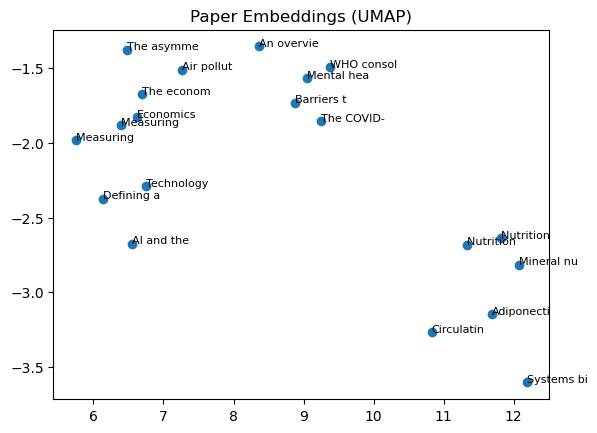

In [44]:
# @title (Optional) Step 6: Visualize with UMAP
import umap
import matplotlib.pyplot as plt

reducer = umap.UMAP()
umap_embeds = reducer.fit_transform(embeddings_np)

length = 20

plt.scatter(umap_embeds[0:length, 0], umap_embeds[0:length, 1])
for i, title in enumerate(df.head(length)['clean_title']):
  plt.annotate(title[:10], (umap_embeds[i, 0], umap_embeds[i, 1]), fontsize=8)
plt.title("Paper Embeddings (UMAP)")
plt.show()